In [24]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../GlacierLakeDetectionICESat2/GlacierLakeIS2ML/')

from IS2ML_utils import *
from figscode import *

import statsmodels.api as sm

def get_ordered_groups(group_size, length):
    np.random.seed(42)
    n_groups, remainder = divmod(length, group_size)
    n_add, remainder = divmod(remainder, n_groups)
    lengthlist = [n_add+1] * remainder + [n_add] * (n_groups - remainder)
    np.random.shuffle(lengthlist)
    addlist = group_size + np.array(lengthlist)
    groups = []
    for i, j in enumerate(addlist):
        groups += [i] * j
    return groups

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
gdf_basins = gpd.read_file('data/shapefiles/ANT_basins_merged.shp')
gdf_imbie = gpd.read_file('data/shapefiles/Basins_Antarctica_v02.shp')
gdf_shelf = gpd.read_file('data/shapefiles/IceShelf_Antarctica_v02.shp')
gdf_coast = gpd.read_file('data/shapefiles/Coastline_Antarctica_v02.shp')
gdf_gl = gpd.read_file('data/shapefiles/GroundingLine_Antarctica_v02.shp')
gdf_names = pd.concat((gdf_imbie.drop(columns=['Asso_Shelf', 'Subregions']),
                       gdf_shelf)).reset_index(drop=True)

fn_lakestats = 'data/FLUID-SuRRF_AIS2019-23_lakestats.csv'
df = pd.read_csv(fn_lakestats)
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)
if ('dist_GL' not in gdf.keys()) or ('dist_coast' not in gdf.keys()):
    gdf['dist_GL'] = gdf.geometry.distance(gdf_gl.boundary.iloc[0])
    gdf.loc[gdf.grounded, 'dist_GL'] *= -1
    gdf['dist_coast'] = gdf.geometry.distance(gdf_coast.boundary.iloc[0])
    gdf.to_csv(fn_lakestats, index=False)

is_good = (gdf.label=='good_lake') & (~gdf.rdepth.isna())
gdfg = gdf[is_good].copy().reset_index(drop=True)
dtformat = '%Y-%m-%dT%H:%M:%SZ'
gdfg['datetime'] = gdfg.date_time.apply(lambda x: datetime.strptime(x, dtformat))
def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
def get_doy(x):
    doy = x.timetuple().tm_yday
    if is_leap_year(x.year):
        if doy == 60: # feb 29
            doy = np.nan
        if doy > 60:
            doy -= 1
    return doy
gdfg['doy'] = gdfg.datetime.apply(get_doy)
doy_start = datetime(2019, 11, 1).timetuple().tm_yday
doy_end = datetime(2019, 3, 31).timetuple().tm_yday
inside_doy_range = (gdfg.doy >= doy_start) | (gdfg.doy <= doy_end)
gdfg.loc[~inside_doy_range, 'doy'] = np.nan
gdfg.loc[gdfg.doy > 200, 'doy'] -= 365

In [27]:
# wais_corr = gpd.read_file('data/zzz_temp/corr/WAIS_Jan_2017_Polygons.shp')
# eais_stokes = gpd.read_file('data/zzz_temp/stokes/Jan_2017_Lakes.shp')
# c1000 = wais_corr.Elevation <= 1000
# s1000 = eais_stokes.Elevation <= 1000
# area1000_stokes = eais_stokes.Area[s1000].sum() / eais_stokes.Area.sum() * 100
# area1000_corr =  wais_corr.Area[c1000].sum() / wais_corr.Area.sum() * 100
# print('%.1f%% of lake area is < 1000m for EAIS (Stokes et al., 2019)' % area1000_stokes)
# print('%.1f%% of lake area is < 1000m for WAIS (Corr et al., 2022)' % area1000_corr)
# print('\n%.1f%% of lakes are < 1000m for EAIS (Stokes et al., 2019)' % (s1000.mean()*100))
# print('%.1f%% of lakes are < 1000m for WAIS (Corr et al., 2022)' % (c1000.mean()*100))

In [28]:
df_stats_ais = pd.read_csv('data/FLUID-SuRRF_AIS2018-23_groupstats.csv')
df_stats_gris = pd.read_csv('../greenland-supraglacial-lake-depths-figures/data/FLUID-SuRRF_GrIS2019-23_groupstats.csv')


In [29]:
df_stats_gris

,group,xatc_total_m,nphot_total,data_mb,n_granules,xatc_water,pct_xatc_water,depth_90pctl,elev_mean,log_qual_mean,doy_mean
0,total,1.224240e+10,1.709707e+11,3.145494e+07,11304.0,4209735.0,0.034387,12.149372,981.138823,1.175579,203.924408
1,CE,9.845941e+08,2.528115e+10,3.115251e+06,902.0,163665.0,0.016623,11.965937,1349.694652,1.061594,202.008130
2,CW,8.237589e+08,8.372163e+09,1.551389e+06,532.0,729780.0,0.088591,12.596210,1164.333057,1.363038,198.766221
3,NE,2.769508e+09,3.961249e+10,6.408843e+06,2245.0,1038800.0,0.037508,11.269271,782.002881,1.115739,208.409910
4,NO,3.306321e+09,3.881244e+10,1.259195e+07,4930.0,759570.0,0.022973,10.898492,678.171570,1.120981,204.036120
5,NW,2.128533e+09,3.101740e+10,4.572173e+06,1486.0,700150.0,0.032894,15.940344,878.679362,1.257276,210.984362
6,SE,7.141371e+08,1.493961e+10,1.579615e+06,646.0,12240.0,0.001714,9.598809,1095.409968,0.988867,204.052632
7,SW,1.515548e+09,1.293542e+10,1.635720e+06,563.0,805530.0,0.053151,9.278767,1392.942646,1.135231,196.632050
8,2019,2.259661e+09,3.103321e+10,5.198778e+06,2083.0,1129105.0,0.049968,13.811320,1066.798382,1.229964,199.159468
9,2020,2.522613e+09,3.208271e+10,6.029418e+06,2329.0,759050.0,0.030090,12.311791,944.072730,1.185656,199.574737


In [30]:
vars_sel = ['group', 'xatc_total_m', 'nphot_total', 'data_mb', 'n_granules', 'xatc_water', 'depth_90pctl', 'elev_mean', 'pct_xatc_water']
totalstats = pd.concat((df_stats_gris[vars_sel].iloc[[0]], df_stats_ais[vars_sel].iloc[[0]])).sum()
totalstats['pct_xatc_water'] = totalstats.xatc_water / totalstats.xatc_total_m * 100
print('IN GREENLAND AND ANTARCTICA COMBINED')
print('%.1f TB of data were processed' % (totalstats.data_mb/1e6))
print('%.1f billion photons' % (totalstats.nphot_total/1e9))
print('%.1g %% percent was lakes' % (totalstats.pct_xatc_water))

IN GREENLAND AND ANTARCTICA COMBINED
138.3 TB of data were processed
765.0 billion photons
0.009 % percent was lakes


In [31]:
pd.concat((df_stats_gris[vars_sel].iloc[[0]], df_stats_ais[vars_sel].iloc[[0]]))

,group,xatc_total_m,nphot_total,data_mb,n_granules,xatc_water,depth_90pctl,elev_mean,pct_xatc_water
0,total,1.224240e+10,1.709707e+11,3.145494e+07,11304.0,4209735.0,12.149372,981.138823,0.034387
0,total,5.467696e+10,5.940318e+11,1.068368e+08,42752.0,2117325.0,5.698306,133.564781,0.003872


# Print some overall statistics from the dataset

In [32]:
df_stats = pd.read_csv('data/FLUID-SuRRF_AIS2018-23_groupstats.csv')
df_stats['depth_print'] = df_stats.depth_90pctl.apply(lambda x: '$%.1f$' % x)
df_stats['elev_print'] = df_stats.elev_mean.apply(lambda x: '$%.0f$' % x)
# df_stats['doy_print'] = df_stats.doy_mean.apply(lambda x: (datetime(2019, 1, 1) + timedelta(days=x-1)).strftime("%b %d"))
df_stats['percent_water_print'] = df_stats.pct_xatc_water.apply(lambda x: '$%.1g$' % x)
df_stats['ngranules_print'] = df_stats.n_granules.apply(lambda x: '$%.0f$' % x)
df_stats['qual_print'] = df_stats.qual_median.apply(lambda x: '$%.2f$' % x)

In [33]:
totals = df_stats[df_stats.group=='total'].iloc[0]
print('In total, we processed %i granules over Greenland.' % totals.n_granules)
print('with a total size of %.0f TB' % (totals.data_mb/1e6))
print('Comprising %.0f million kilometers of along-track data' % (totals.xatc_total_m/1e9))
print('and about %.0f billion geolocated photons.' % (totals.nphot_total/1e9))
print('\nIn total, %.2g%% of along-track distance was surface of supraglacial lakes with visible lakebed.' % totals.pct_xatc_water)
print('amounting to %.0f km of along-track lake depth data' % (totals.xatc_water/1e3))
print('mean of >90th percentile depth: %.3g m' % totals.depth_90pctl)
print('mean elevation: %.0f m' % totals.elev_mean)
print('mean date: %s' % totals.doy_str)
print('\n%.1f%% of lakes are on the floating ice shelves.' % (gdfg.grounded.mean()*100))
display(df_stats)

In total, we processed 42752 granules over Greenland.
with a total size of 107 TB
Comprising 55 million kilometers of along-track data
and about 594 billion geolocated photons.

In total, 0.0039% of along-track distance was surface of supraglacial lakes with visible lakebed.
amounting to 2117 km of along-track lake depth data
mean of >90th percentile depth: 5.7 m
mean elevation: 134 m
mean date: Jan 21

39.2% of lakes are on the floating ice shelves.


,group,xatc_total_m,nphot_total,data_mb,n_granules,n_lakes,n_lakes_depth,xatc_water,pct_xatc_water,depth_90pctl,elev_mean,qual_median,doy_mean,doy_str,depth_print,elev_print,percent_water_print,ngranules_print,qual_print
0,total,5.467696e+10,5.940318e+11,1.068368e+08,42752,3559,2118,2117325.0,0.003872,5.698306,133.564781,1.071876,21.121382,Jan 21,$5.7$,$134$,$0.004$,$42752$,$1.07$
1,2018-19,1.082641e+10,1.142670e+11,1.804596e+07,8434,1147,703,747960.0,0.006909,4.873082,142.638606,1.146657,11.000000,Jan 11,$4.9$,$143$,$0.007$,$8434$,$1.15$
2,2019-20,1.120923e+10,1.132542e+11,2.121775e+07,8701,1022,627,655090.0,0.005844,6.512125,119.368964,1.207474,30.000000,Jan 30,$6.5$,$119$,$0.006$,$8701$,$1.21$
3,2020-21,1.077093e+10,1.228087e+11,2.251388e+07,8484,460,240,225465.0,0.002093,6.029893,135.898929,0.838368,20.000000,Jan 20,$6.0$,$136$,$0.002$,$8484$,$0.84$
4,2021-22,1.098725e+10,1.254473e+11,2.296016e+07,8629,569,348,296485.0,0.002698,5.093209,172.170806,1.174860,18.000000,Jan 18,$5.1$,$172$,$0.003$,$8629$,$1.17$
5,2022-23,1.088314e+10,1.182546e+11,2.209902e+07,8504,361,200,192325.0,0.001767,6.202128,81.099164,0.711970,29.000000,Jan 29,$6.2$,$81$,$0.002$,$8504$,$0.71$
6,East,2.258627e+10,2.799528e+11,5.828950e+07,22473,2947,1755,1787340.0,0.007913,5.551815,148.807814,1.118342,17.000000,Jan 17,$5.6$,$149$,$0.008$,$22473$,$1.12$
7,Peninsula,3.888936e+09,6.001780e+10,7.333658e+06,2184,530,319,282185.0,0.007256,6.582306,39.040831,0.818437,35.000000,Feb 04,$6.6$,$39$,$0.007$,$2184$,$0.82$
8,West,2.820176e+10,2.540612e+11,4.121361e+07,18095,82,44,47800.0,0.000169,4.599640,196.692536,1.148706,2.000000,Jan 02,$4.6$,$197$,$0.0002$,$18095$,$1.15$
9,A-Ap,2.620883e+09,3.943233e+10,6.783670e+06,2664,256,118,187180.0,0.007142,5.301472,56.499775,0.774608,21.000000,Jan 21,$5.3$,$56$,$0.007$,$2664$,$0.77$


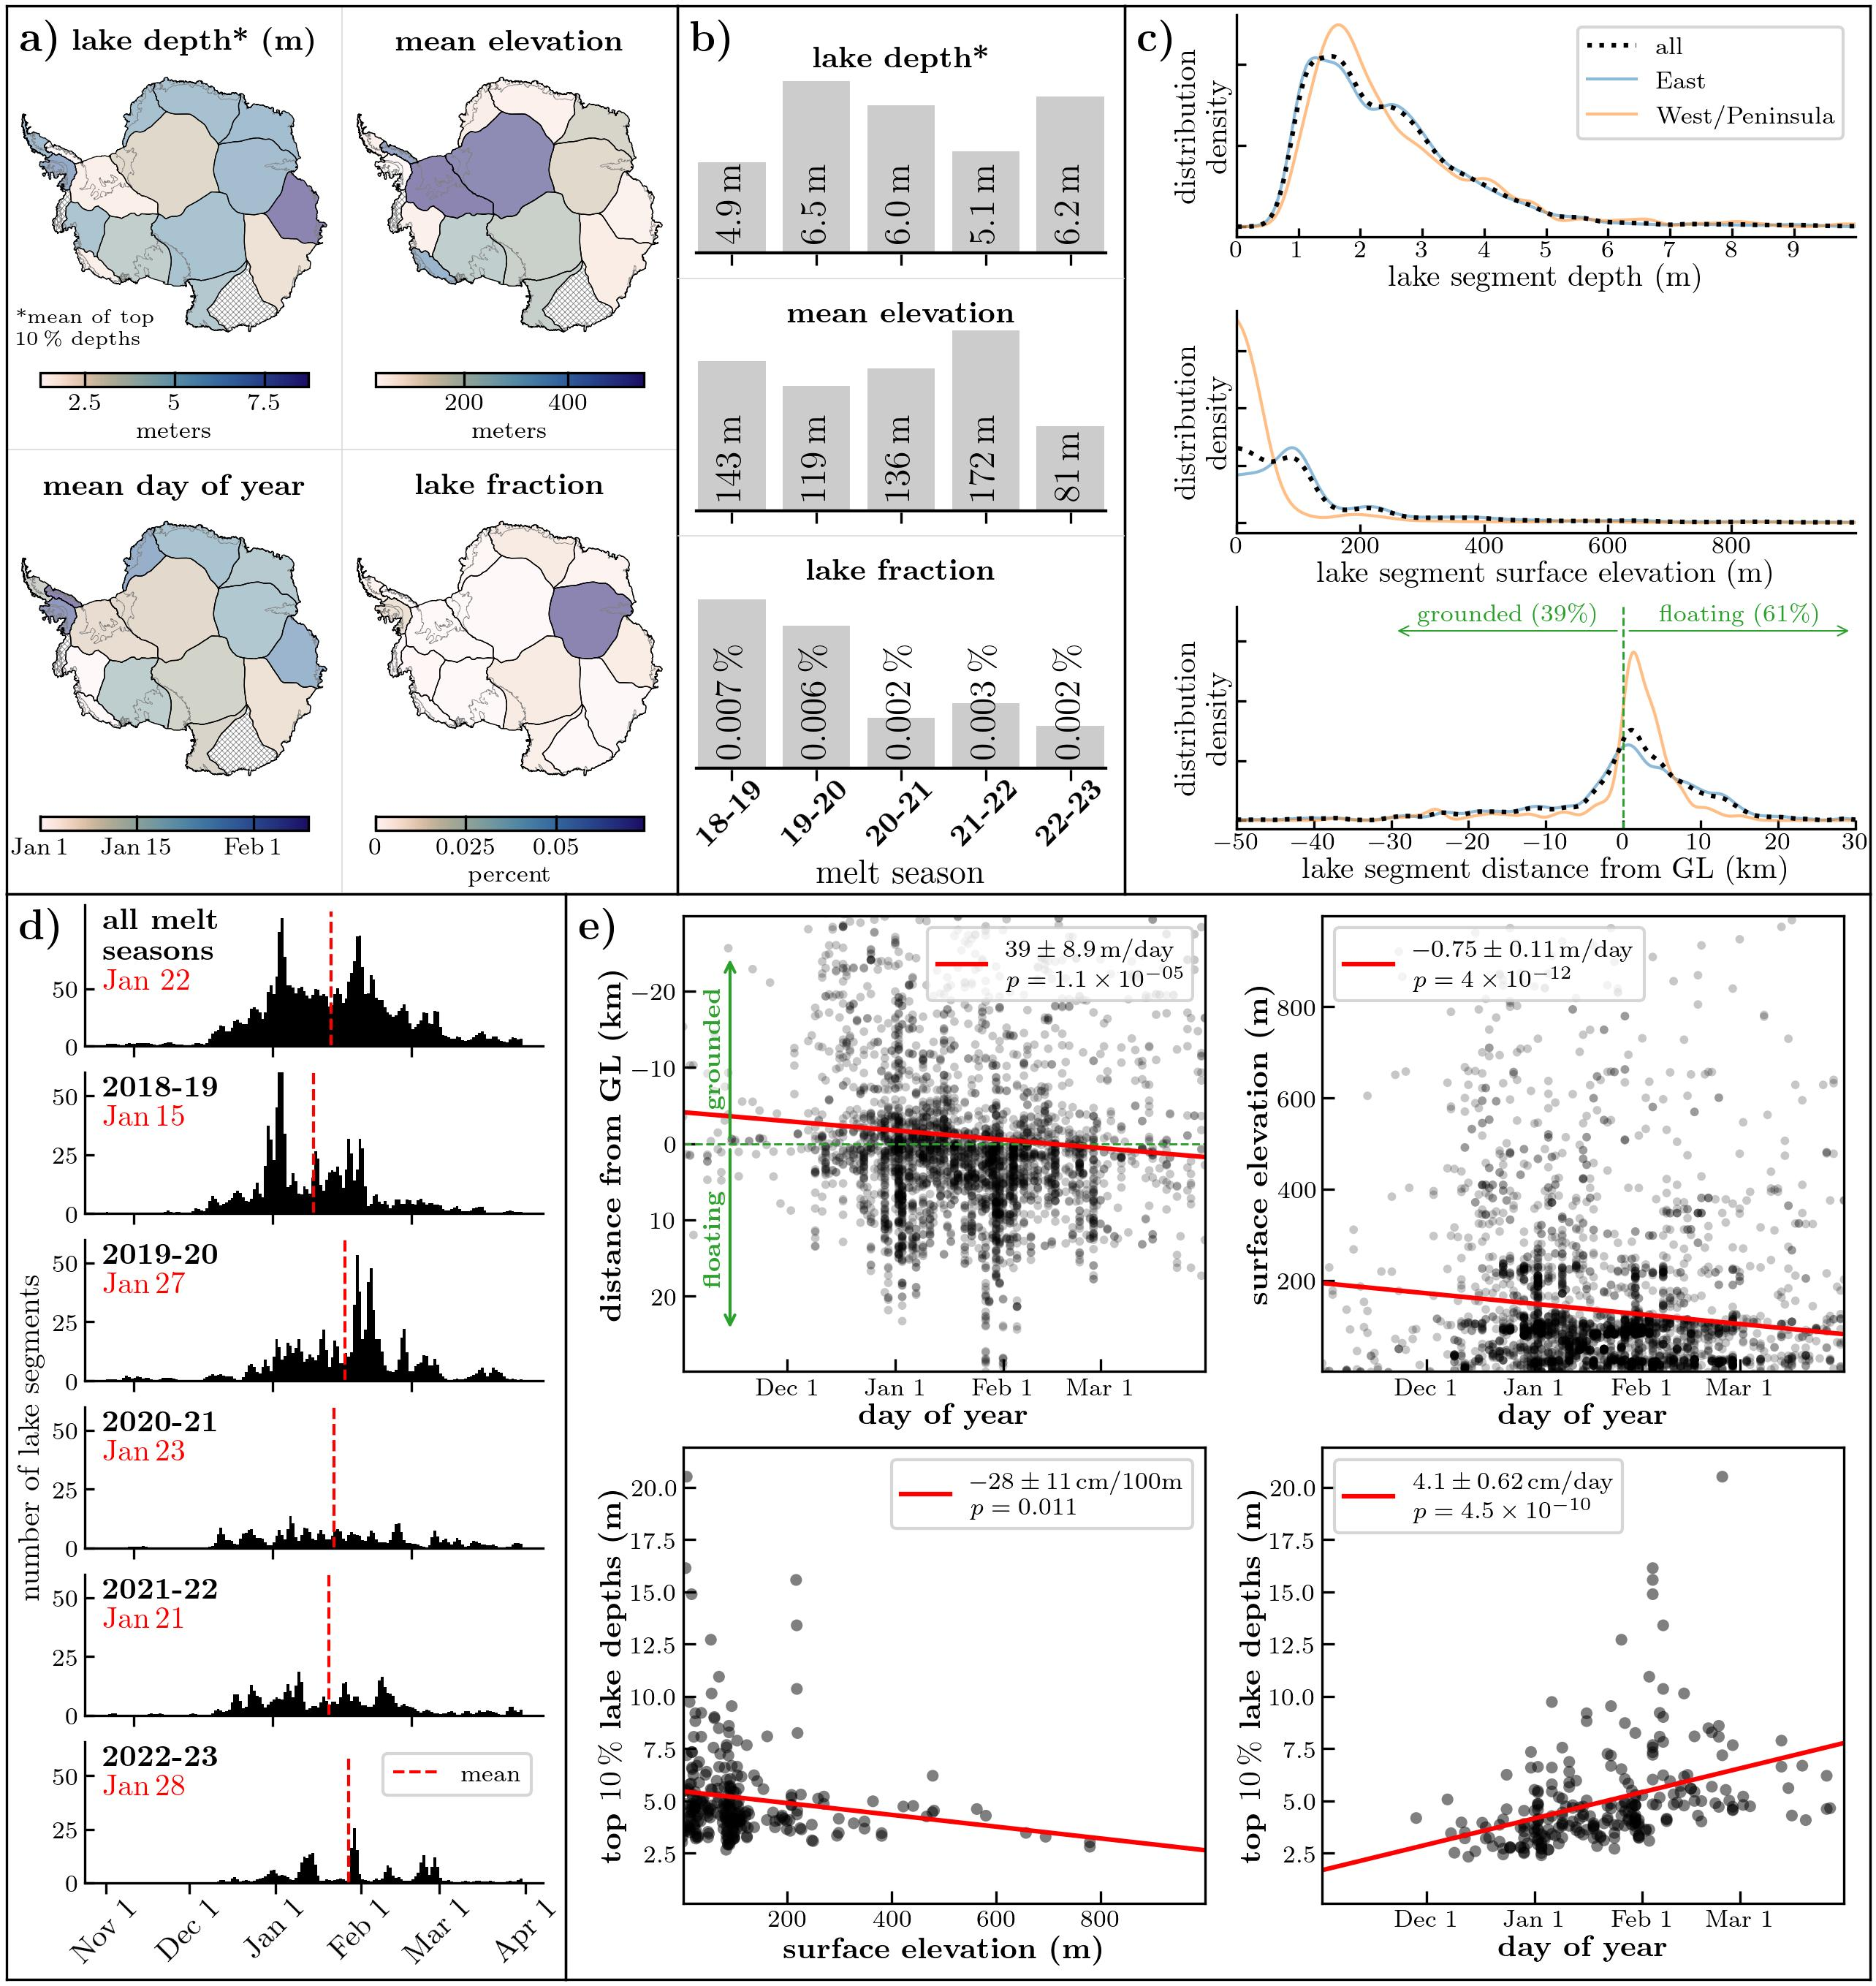

In [34]:
plt.close('all')
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

plt.rc("hatch", linewidth=0.2)

def ith_letter(i):
    return chr(97 + i)

plot_scatter = True
plot_timing = True
plot_elevs = True
plot_depths = True
plot_distgl = True
plot_regions = True
plot_years = True

figwid = 8.5
fighgt = 9
fig = plt.figure(figsize=[figwid,fighgt], dpi=110)

tempsize = 16
templabels = ['scatter plots', 'timing\nhistograms', 'elev distributions', 'depth distributions', 'stats by region', 'stats\nby\nyear']
sep_lw = 0.4
sep_color = [0.85]*3

w_scatt = 0.7
h_scatt = 0.55
w_elev_dep = 0.4
frac_regions = 0.6

coords_scatters = [1-w_scatt, 0, w_scatt, h_scatt]
box_scatters = fig.add_axes(coords_scatters)
coords_timing = [0, 0, 1-w_scatt, h_scatt]
box_timing = fig.add_axes(coords_timing)

coords_distgl = [1-w_elev_dep, h_scatt, w_elev_dep, (1-h_scatt)/3]
box_distgl = fig.add_axes(coords_distgl)
coords_elev = [1-w_elev_dep, h_scatt+(1-h_scatt)/3, w_elev_dep, (1-h_scatt)/3]
box_elev = fig.add_axes(coords_elev)
coords_depth = [1-w_elev_dep, h_scatt+(1-h_scatt)*2/3, w_elev_dep, (1-h_scatt)/3]
box_depth = fig.add_axes(coords_depth)

coords_distribs = [1-w_elev_dep, h_scatt, w_elev_dep, (1-h_scatt)]
box_distribs = fig.add_axes(coords_distribs)

# coords_elev = [1-w_elev_dep, h_scatt, w_elev_dep, (1-h_scatt)/2]
# box_elev = fig.add_axes(coords_elev)
# coords_depth = [1-w_elev_dep, h_scatt+(1-h_scatt)/2, w_elev_dep, (1-h_scatt)/2]
# box_depth = fig.add_axes(coords_depth)
coords_regions = [0, h_scatt, (1-w_elev_dep)*frac_regions, 1-h_scatt]
box_regions = fig.add_axes(coords_regions)
coords_years = [(1-w_elev_dep)*frac_regions, h_scatt, (1-w_elev_dep)*(1-frac_regions), 1-h_scatt]
box_years = fig.add_axes(coords_years)

boxes = [box_scatters, box_timing, box_depth, box_elev, box_distgl, box_regions, box_years, box_distribs]

for ib, box in enumerate(boxes):
    box.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
    # box.text(0.5, 0.5, templabels[ib], ha='center', va='center', color='red', fontsize=tempsize, transform=box.transAxes, zorder=1000)
    box.set_facecolor('none')

###########################################################################################################
#### REGION STATS
###########################################################################################################
if plot_regions:
    box = box_regions
    axs_regions = []
    t = 0.0
    tt = 0.0
    b = 0.035
    h = (1-b)/2
    axs_regions.append(box.inset_axes([0, 0.5+b, 0.5, h]))
    axs_regions.append(box.inset_axes([0.5, 0.5+b, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))
    axs_regions.append(box.inset_axes([0, b, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))
    axs_regions.append(box.inset_axes([0.5, b, 0.5, h], sharex=axs_regions[0], sharey=axs_regions[0]))

    # separating lines
    box.add_line(Line2D([0.5, 0.5], [0, 1], color=sep_color, lw=sep_lw, transform=box.transAxes))
    box.add_line(Line2D([0, 1], [(1-tt)/2]*2, color=sep_color, lw=sep_lw, transform=box.transAxes))

    txt_bbx = dict(facecolor='white', alpha=0.95, edgecolor='none', boxstyle="Round, pad=0.1")
    box.text(0.015, 0.615, '*mean of top\n$10\\mathrm{\\,\\%}$ depths', ha='left', va='bottom', transform=box.transAxes, fontsize=6.5, 
             # bbox=txt_bbx, 
             zorder=9999999)
    
    basins = gdf_basins.rename(columns={'Subregions':'basin'}).merge(df_stats.rename(columns={'group':'basin'}), on='basin', how='left')

    cmap_regions = cmc.lapaz_r
    alpha = 0.5
    lw = 0.3
    tit_size = 10
    hatchstyle = 'XXXXXXXXXXXXX'
    lw_hatch = 0.3
    
    for ax in axs_regions:
        basins.boundary.plot(ax=ax, edgecolor='k', linewidth=lw, zorder=5)
        gdf_gl.boundary.plot(ax=ax, color='gray', lw=0.2, zorder=4)
        ax.axis('off')
        # ax.set_xlim((-750000, 898000))
        # ax.set_ylim((-3430000, -640000))

    # Set the scalar formatter
    def add_cbar_region(ax, label, vmin, vmax, cmap=cmap_regions, fontsize=8):
        cax = ax.inset_axes([0.1, -0.15, 0.8, 0.05])
        smap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        smap._A = []
        cbar = plt.colorbar(smap, cax=cax, orientation='horizontal')
        cax.set_xlabel(label, fontsize=fontsize, labelpad=2)
        cax.tick_params(axis='x', direction='in', length=5, pad=2)
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False) 
        cax.xaxis.set_major_formatter(formatter)
        cax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:g}'))
        return cax

    ytxt = 1.03
    ax = axs_regions[0]
    stat = 'depth_90pctl'
    smp = basins.plot(ax=ax, column=stat, cmap=cmap_regions, edgecolor='none', alpha=alpha)
    nodat = basins[basins[stat].isna()].plot(ax=ax, hatch=hatchstyle, facecolor='none', edgecolor='gray', linewidth=0, alpha=1)
    # basins.apply(print_stat_map, stat='depth_print', ax=ax, axis=1)
    ax.text(0.56, ytxt, '\\textbf{lake depth* (m)}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    add_cbar_region(ax, label='meters', vmin=basins[stat].min(), vmax=basins[stat].max())
    
    ax = axs_regions[1]
    stat = 'elev_mean'
    smp = basins.plot(ax=ax, column=stat, cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    nodat = basins[basins[stat].isna()].plot(ax=ax, hatch=hatchstyle, facecolor='none', edgecolor='gray', linewidth=0, alpha=1)
    # basins.apply(print_stat_map, stat='elev_print', ax=ax, axis=1)
    ax.text(0.5, ytxt, '\\textbf{mean elevation}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    add_cbar_region(ax, label='meters', vmin=basins[stat].min(), vmax=basins[stat].max())
    
    ax = axs_regions[2]
    stat = 'doy_mean'
    smp = basins.plot(ax=ax, column=stat, cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    nodat = basins[basins[stat].isna()].plot(ax=ax, hatch=hatchstyle, facecolor='none', edgecolor='gray', linewidth=0, alpha=1)
    # basins.apply(print_stat_map, stat='doy_print', ax=ax, axis=1)
    ax.text(0.5, ytxt, '\\textbf{mean day of year}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    cax = add_cbar_region(ax, label=' ', vmin=basins[stat].min(), vmax=basins[stat].max())
    dt_list = [datetime(2019,1,1), datetime(2019,1,15),datetime(2019,2,1)]
    doy_list = [x.timetuple().tm_yday for x in dt_list]
    ylab_list = [x.strftime('%b$\mathrm{\,}$%-d') for x in dt_list]
    cax.set_xticks(doy_list, labels=ylab_list)
    
    ax = axs_regions[3]
    stat = 'pct_xatc_water'
    smp = basins.plot(ax=ax, column=stat, cmap=cmap_regions, edgecolor='k', linewidth=lw, alpha=alpha)
    # nodat = basins[basins[stat].isna()].plot(ax=ax, hatch=hatchstyle, facecolor='none', edgecolor='gray', linewidth=0, alpha=1)
    # basins.apply(print_stat_map, stat='percent_water_print', ax=ax, axis=1)
    ax.text(0.5, ytxt, '\\textbf{lake fraction}', ha='center', va='bottom', transform=ax.transAxes, fontsize=tit_size)
    add_cbar_region(ax, label='percent', vmin=basins[stat].min(), vmax=basins[stat].max())

###########################################################################################################
#### YEAR/SEASON STATS
###########################################################################################################
if plot_years:
    box = box_years
    yrs = df_stats.set_index('group').loc[['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']].copy()
    xs = np.arange(2019, 2024)
    
    b = 0.04
    bb = 0.1
    tt = 0.03
    ny = 3
    h = (1-b*ny-bb-tt)/ny
    fc = [0.8]*3
    # fc=cmc.grayC(np.linspace(0.15, 0.35, 5))
    tit_size = 10
    txt_y = 0.95
    yf = 0.05
    labsz = 12

    box.text(0.5, 0.005, 'melt season', ha='center', va='bottom', fontsize=11)
    axs_years = []
    for i in range(ny):
        ypos = 1-(i+1)*h-i*b-tt
        axs_years.append(box.inset_axes([0, ypos, 1, h]))
        if i < (ny-1):
            box.add_line(Line2D([0, 1], [ypos-b*2/3]*2, color=sep_color, lw=sep_lw, transform=box.transAxes, zorder=100))

    iax_years = 0
    ax = axs_years[iax_years]
    yl = (3,7.5)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.depth_90pctl, color=fc)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, '$%s\\mathrm{\\,m}$' % yrs.depth_print.iloc[ib].replace('$',''), 
             ha='center', va='bottom', rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{lake depth*}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)

    iax_years += 1
    ax = axs_years[iax_years]
    yl = (0,210)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.elev_mean, color=fc)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, '$%s\\mathrm{\\,m}$' % yrs.elev_print.iloc[ib].replace('$',''),
             ha='center', va='bottom', rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{mean elevation}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)

    iax_years += 1
    ax = axs_years[iax_years]
    yl = (0,0.009)
    yrng = yl[1]-yl[0]
    bars = ax.bar(xs, yrs.pct_xatc_water, color=fc)
    yrs['percent_water_print'] = yrs.pct_xatc_water.apply(lambda x: '$%.3f$' % x)
    [ax.text(bar.get_x()+bar.get_width()/2, yl[0]+yf*yrng, '$%s\\mathrm{\\,\\%%}$' % yrs.percent_water_print.iloc[ib].replace('$',''),
             ha='center', va='bottom', rotation='vertical', fontsize=labsz) for ib,bar in enumerate(bars)]
    ax.set_ylim(yl)
    ax.text(0.5, txt_y, '\\textbf{lake fraction}', ha='center', va='top', transform=ax.transAxes, fontsize=tit_size)
    ax.set_xticks(np.arange(2019,2024), ["\\textbf{%d-%d}" % (x,x+1) for x in np.arange(18,23)],fontsize=10, rotation=45)
    ax.tick_params(axis='x', pad=-2)
    
    for iax, ax in enumerate(axs_years):
        ax.set_facecolor('none')
        ax.plot([2018.6, 2023.4], [ax.get_ylim()[0]]*2, 'k-', lw=2, zorder=100)
        for spine in ax.spines.values():
            spine.set_visible(False)
        labelbottom = True if iax == (ny - 1) else False
        ax.tick_params(left=False,labelbottom=labelbottom,labelleft=False)

###########################################################################################################
#### SEASON TIMING
###########################################################################################################
if plot_timing:
    box = box_timing
    box.text(0.02, 0.5, 'number of lake segments', fontsize=10, rotation=90, ha='center', va='top', transform=box.transAxes, rotation_mode='anchor')
    ny = 6
    b = 0.014
    bb = 0.065
    t = 0.01
    tt = 0.01
    l = 0.14
    r = 0.04
    h = (1-b*ny-tt*ny-bb-t)/ny
    axs_timing = []
    for i in range(ny):
        axs_timing.append(box.inset_axes([l, 1-(i+1)*h-i*b-i*tt-t, 1-l-r, h]))
    for ax in axs_timing[:-1]:
        ax.tick_params(axis='both', which='both', labelbottom=False)

    year_list = list(np.sort(gdfg.melt_season.unique()))
    dt_list = [datetime(2019,i,1) for i in [11,12,1,2,3,4]]
    doy_list = np.array([x.timetuple().tm_yday for x in dt_list])
    doy_list[doy_list>200] = doy_list[doy_list>200] - 365
    ylab_list = [x.strftime('%b %-d') for x in dt_list]
    
    bins = np.arange(gdfg.doy.min()-0.5, gdfg.doy.max()+0.5)
    mids = bins[:-1] + np.diff(bins)
    txtx = 0.04
    txty = 0.98
    
    ax = axs_timing[0]
    hist = np.histogram(gdfg.doy, bins)
    hist_smooth = pd.Series(hist[0]).rolling(window=10, center=True, min_periods=1, win_type='gaussian').mean(std=1)
    ax.bar(mids, hist_smooth, width=1.0, color='k')
    daymean = gdfg.doy.mean()
    daymean_forstr = daymean.copy()
    if daymean < 1:
        daymean_forstr = daymean + 365
    daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean_forstr)).strftime("%b %d")
    ax.text(txtx, 0.55, daymean_str, color='red', ha='left', va='top',fontsize=10, transform=ax.transAxes)
    yl = ax.get_ylim()
    ax.plot([daymean]*2, yl, color='r', lw=1, ls='--')
    ax.text(txtx, txty, '\\textbf{all melt}\n\\textbf{seasons}', ha='left', va='top', transform=ax.transAxes, fontsize=10)
    ax.set_yticks([0,50])
    
    for iyr, yr in enumerate(year_list):
        ax = axs_timing[iyr+1]
        gdfgyr = gdfg[gdfg.melt_season == yr].copy()
        hist = np.histogram(gdfgyr.doy, bins)
        hist_smooth = pd.Series(hist[0]).rolling(window=5, center=True, min_periods=1, win_type='gaussian').mean(std=1)
        ax.bar(mids, hist_smooth, width=1.0, color='k')
        daymean = gdfgyr.doy.mean()
        daymean_str = (datetime(2019, 1, 1) + timedelta(days=daymean)).strftime("%b$\mathrm{\,}$%d")
        ax.text(txtx, 0.77, daymean_str, color='red', ha='left', va='top',fontsize=10, transform=ax.transAxes)
        yl = (0,60)
        ax.set_ylim(yl)
        p_mean, = ax.plot([daymean]*2, yl, color='r', lw=1, ls='--', label='mean')
        ax.text(txtx, txty, '\\textbf{%s}' % yr, ha='left', va='top', transform=ax.transAxes, fontsize=10)
        ax.set_yticks([0, 25, 50])

    axs_timing[-1].legend(handles=[p_mean], loc='upper right')
    ax.set_xticks(doy_list, labels=ylab_list ,fontsize=10, rotation=45)
    ax.tick_params(axis='x', pad=0)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0], yl[1] + 0.1 * (yl[1] - yl[0]))
    # safehold_date = datetime(2019, 7, 4)
    # safehold_doy = safehold_date.timetuple().tm_yday
    # axs_timing[1].text(safehold_doy, 5, '← safehold', ha='center', va='bottom', rotation='vertical', color='blue', fontsize=8.5)

    for ax in axs_timing:
        ax.tick_params(axis='y', direction='in', length=3, pad=2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

###########################################################################################################
#### DEPTH DISTRIBUTION
###########################################################################################################
l = 0.15
r = 0.02
t = 0.03
b = 0.22
lab_ypad = 1.5
lab_xpad = 0.3
tick_ypad = 1
gdfg['mainregions'] = 'East'
gdfg.loc[gdfg.region == 'West', 'mainregions'] = 'West/Peninsula'
gdfg.loc[gdfg.region == 'Peninsula', 'mainregions'] = 'West/Peninsula'

if plot_depths:
    box = box_depth
    ax = box.inset_axes([l, b, 1-l-r, 1-b-t])

    basin_list = ['East', 'West', 'Peninsula'] # could probably lump together West and Peninsula
    basin_list = ['East', 'West/Peninsula']
    year_list = np.arange(2019,2024)

    maxdepth = 11
    step_hist = 0.01
    smooth_len = 0.2
    xl = [0, 9.99]
    gdfnnz = gdfg[gdfg.rdepth > 0].copy()
    #gdfnnz = gdfg.copy()
    bins = np.arange(0,maxdepth+step_hist, step_hist)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(gdfnnz.rdepth, bins=bins, density=True)
    wdw = int(np.ceil(smooth_len/step_hist))
    hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    ax.plot(mids, hist_smooth, 'k:', zorder=10, label='all')
    for ib, bas in enumerate(basin_list):
        dfb = gdfnnz[gdfnnz.mainregions==bas].copy()
        hist_bs = np.histogram(dfb.rdepth, bins=bins, density=True)
        hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
        ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(xl)
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0], yl[1] + 0.1 * (yl[1] - yl[0]))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('lake segment depth (m)', fontsize=10, labelpad=lab_xpad)
    ax.set_ylabel('distribution\ndensity', fontsize=10, labelpad=lab_ypad)
    ax.tick_params(axis='both', direction='in', length=3, pad=tick_ypad)
    ax.set_facecolor('none')
    ax.tick_params(labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

###########################################################################################################
#### ELEVATION DISTRIBUTION
###########################################################################################################
if plot_elevs:
    box = box_elev
    ax = box.inset_axes([l, b, 1-l-r, 1-b-t])

    maxelev = 1000
    step_hist = 2
    smooth_len = 25
    xl = [0, 999.9]
    bins = np.arange(0,maxelev+step_hist, step_hist)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(gdfg.surface_elevation, bins=bins, density=True)
    wdw = int(np.ceil(smooth_len/step_hist))
    hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    
    ax.plot(mids, hist_smooth, 'k:', zorder=10, label='all')
    for bas in basin_list:
        dfb = gdfg[gdfg.mainregions==bas].copy()
        hist_bs = np.histogram(dfb.surface_elevation, bins=bins, density=True)
        hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
        ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
    
    # ax.legend(loc='upper right', fontsize=8)
    ax.set_xlim(xl)
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0], yl[1] + 0.1 * (yl[1] - yl[0]))
    ax.set_xlabel('lake segment surface elevation (m)', fontsize=10, labelpad=lab_xpad)
    ax.set_ylabel('distribution\ndensity', fontsize=10, labelpad=lab_ypad)
    ax.tick_params(axis='both', direction='in', length=3, pad=tick_ypad)
    ax.set_facecolor('none')
    ax.tick_params(labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

###########################################################################################################
#### DISTANCE FROM GROUNDING LINE DISTRIBUTION
###########################################################################################################
if plot_distgl:
    box = box_distgl
    ax = box.inset_axes([l, b, 1-l-r, 1-b-t])

    mindist = -100
    maxdist = 40
    step_hist = 0.1
    smooth_len = 1
    xl = [-50, 30]
    bins = np.arange(mindist,maxdist+step_hist, step_hist)
    mids = bins[:-1] + np.diff(bins)
    hist = np.histogram(gdfg.dist_GL/1000, bins=bins, density=True)
    wdw = int(np.ceil(smooth_len/step_hist))
    hist_smooth = pd.Series(hist[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
    
    ax.plot(mids, hist_smooth, 'k:', zorder=10, label='all')
    for bas in basin_list:
        dfb = gdfg[gdfg.mainregions==bas].copy()
        hist_bs = np.histogram(dfb.dist_GL/1000, bins=bins, density=True)
        hist_bs_smooth = pd.Series(hist_bs[0]).rolling(window=wdw*10, min_periods=1, center=True, win_type='gaussian').mean(std=wdw)
        ax.plot(mids, hist_bs_smooth, alpha=0.5, lw=1, label=bas)
    
    # ax.legend(loc='upper left', fontsize=8)
    ax.set_xlim(xl)
    yl = ax.get_ylim()
    ax.set_ylim(yl[0], yl[1] + 0.2 * (yl[1] - yl[0]))

    ax.axvline(0, color='C2', lw=0.7, ls='--')
    xrng = 30
    yrng = (yl[1] - yl[0])
    txty = yl[1] + 0.07*yrng
    perc_grounded = gdfg.grounded.mean() * 100
    fs_arr = 8
    ax.annotate('', xy=(xrng, txty), xytext=(0.0, txty), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->', lw=0.5))
    ax.text(xrng/2, txty+0.025*yrng, 'floating ($%.0f\\%%$)' % (100-perc_grounded), ha='center', va='bottom', color='C2', fontsize=fs_arr)
    ax.annotate('', xy=(-xrng, txty), xytext=(0.0, txty), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->', lw=0.5))
    ax.text(-xrng/2, txty+0.025*yrng, 'grounded ($%.0f\\%%$)' % perc_grounded, ha='center', va='bottom', color='C2', fontsize=fs_arr)
    
    ax.set_xlabel('lake segment distance from GL (km)', fontsize=10, labelpad=lab_xpad)
    ax.set_ylabel('distribution\ndensity', fontsize=10, labelpad=lab_ypad)
    ax.tick_params(axis='both', direction='in', length=3, pad=tick_ypad)
    ax.set_facecolor('none')
    ax.tick_params(labelleft=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

###########################################################################################################
#### SCATTER PLOTS
###########################################################################################################
if plot_scatter:
    box = box_scatters
    l = 0.09
    b = 0.07
    r = 0.01
    t = 0.01
    w = (1 - (l+r)*2) / 2
    h = (1 - (b+t)*2) / 2
    axs_scatt = []
    axs_scatt.append(box.inset_axes([l, b*2+h, w, h]))
    axs_scatt.append(box.inset_axes([l*2+w, b*2+h, w, h]))
    axs_scatt.append(box.inset_axes([l, b, w, h]))
    axs_scatt.append(box.inset_axes([l*2+w, b, w, h]))
    
    group_size = 25
    min_elev = 0
    quantile = 0.9
    descr_fsz = 7
    # km_per_lat = 111
    # gdfnnz = gdfg[gdfg.max_depth > 0].copy()
    # gdfnnz = gdfnnz[gdfnnz.is_grounded]

    # date labels
    dt_list = [datetime(2019,i,1) for i in [12,1,2,3]]
    doy_list = np.array([x.timetuple().tm_yday for x in dt_list])
    doy_list[doy_list>200] = doy_list[doy_list>200] - 365
    ylab_list = [x.strftime('%b %-d') for x in dt_list]
    
    def get_model(dffit, x, y, xlim=None, ylim=None, units=None, uncertainty='standard error', conf_level=0.05):
        model = sm.OLS(dffit[y], sm.add_constant(dffit[x])).fit()
        slope = model.params[1]
        # ci = np.abs(model.params[1] - model.conf_int().iloc[1,0])
        ci = model.conf_int(alpha=conf_level)[1]
        se = model.bse[1]
        if uncertainty == 'standard error':
            uncert = se
        elif uncertainty == 'confidence interval':
            uncert = ci
        else: 
            print('Please choose one of the following for parameter "uncertainty": "standard error" or "confidence interval"')
        pval = ('%.2g' % model.pvalues[1]).replace('e', '\\times 10^{')
        if '{' in pval:
            pval = pval + '}'
        if units:
            if 'factor' in units.keys():
                slope *= units['factor']
                uncert *= units['factor']
        label = '$%.2g \\pm %.2g$\n$p=%s$' % (slope, uncert, pval)
        if units:
            label = label.replace('$\n', '\\mathrm{\\,%s}/\\mathrm{%s}$\n' % (units['y'], units['x']))
        if not xlim:
            xlim = (dffit[x].min(), dffit[x].max())
        if not ylim:
            ylim = (dffit[y].min(), dffit[y].max())
        pred_x = np.linspace(xlim[0], xlim[1])
        pred_y = model.predict(sm.add_constant(pred_x))
        return ({'slope': slope, 'ci': ci, 'se': se, 'conf_level': conf_level,'pval': model.pvalues[1], 'label': label}, 
                {'x': pred_x, 'y': pred_y})
        
    def get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=30):
        df_sorted = dffit.sort_values(by=x).reset_index(drop=True)
        df_sorted['group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
        dfs = []
        for g in df_sorted.group.unique():
            thisdf = df_sorted[df_sorted.group == g]
            dfs.append(thisdf[thisdf[y] >= thisdf[y].quantile(quantile)])
        return pd.concat(dfs)
    
    txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.3")
    xlab_pad = 1
    ylab_pad = 1
    lab_size = 10
    dot_size = 15
    dot_alpha = 0.5
    dot_size_full = 8
    dot_alpha_full = 0.22

    lims = {
        'doy': (gdfg.doy.min(), gdfg.doy.max()),
        'dist_GL_km': (-29.9, 29.9),
        'surface_elevation': (0.1, 999.9),
        'rdepth': (0.1, 21.9),
    }

    axlabs = {
        'doy': 'day of year',
        'dist_GL_km': 'distance from GL (km)',
        'surface_elevation': 'surface elevation (m)',
        'rdepth': 'top $10\\mathrm{\\,\\%}$ lake depths (m)',
    }

    uncert_mode = 'standard error'

    ###############
    # scatter doy vs. dist_GL
    ax = axs_scatt[0]
    x = 'doy'
    y = 'dist_GL_km'
    units = {'x': 'day', 'y': 'm', 'factor': 1000}
    dffit = gdfg.copy()
    dffit[y] = dffit.dist_GL/1000
    pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
    scatt = ax.scatter(dffit[x], dffit[y], s=dot_size_full, color='k', alpha=dot_alpha_full, edgecolors='none')
    ax.axhline(0, color='C2', ls='--', lw=0.7)
    ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
    
    # ax.text(txtx, 0.0, '\\textbf{$\\boldsymbol{\\longrightarrow}$ upstream}', ha='center', va='bottom', rotation=90, color='C2')
    # ax.text(txtx, 0.0, '\\textbf{downstream $\\boldsymbol{\\longleftarrow}$}', ha='center', va='top', rotation=90, color='C2')
    yrng = 25
    xrng = (lims[x][1] - lims[x][0])
    txtx = lims[x][0] + 0.09*xrng
    txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.1")
    ax.annotate('', xy=(txtx, yrng), xytext=(txtx, 0.0), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->'))
    ax.text(txtx-0.01*xrng, yrng/2, '\\textbf{floating}', ha='right', va='center', rotation=90, color='C2', bbox=txt_bbx)
    ax.annotate('', xy=(txtx, -yrng), xytext=(txtx, 0.0), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->'))
    ax.text(txtx-0.01*xrng, -yrng/2, '\\textbf{grounded}', ha='right', va='center', rotation=90, color='C2', bbox=txt_bbx)
    ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
    ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
    ax.set_xlim(lims[x])
    ax.set_ylim(np.flip(lims[y]))
    ax.legend(loc='upper right')
    ax.set_xticks(doy_list, labels=ylab_list)

    ###############
    # scatter doy vs. elev
    ax = axs_scatt[1]
    x = 'doy'
    y = 'surface_elevation'
    units = {'x': 'day', 'y': 'm'}
    dffit = gdfg.copy()
    pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
    scatt = ax.scatter(dffit[x], dffit[y], s=dot_size_full, color='k', alpha=dot_alpha_full, edgecolors='none')
    ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
    ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
    ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
    ax.set_xlim(lims[x])
    ax.set_ylim(lims[y])
    ax.legend(loc='upper left')
    ax.set_xticks(doy_list, labels=ylab_list)

    ###############
    # scatter elev vs. depth
    ax = axs_scatt[2]
    x = 'surface_elevation'
    y = 'rdepth'
    units = {'x': '100m', 'y': 'cm', 'factor': 10000}
    dffit = gdfg[gdfg.rdepth>0].copy()
    dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
    pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
    scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
    ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
    ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
    ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
    ax.set_xlim(lims[x])
    ax.set_ylim(lims[y])
    ax.legend(loc='upper right')

    ###############
    # scatter doy vs. depth
    ax = axs_scatt[3]
    x = 'doy'
    y = 'rdepth'
    units = {'x': 'day', 'y': 'cm', 'factor': 100}
    dffit = gdfg[gdfg.rdepth>0].copy()
    dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
    pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
    scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
    ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
    ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
    ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
    ax.set_xlim(lims[x])
    ax.set_ylim(lims[y])
    ax.legend(loc='upper left')
    ax.set_xticks(doy_list, labels=ylab_list)
    
    for ax in axs_scatt:
        ax.tick_params(axis='both', direction='in', length=4, pad=2)
        ax.set_facecolor('none')


#######################################
# boxes = [box_regions, box_years, box_depth, box_elev, box_distgl, box_timing, box_scatters]
distbxs = [box_depth, box_elev, box_distgl]
for bx in distbxs:
    bx.axis('off')
boxes = [box_regions, box_years, box_depth, box_timing, box_scatters]
letter_pad_x = 0.01
letter_size = 14
letter_bbx = dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle="Round, pad=0.1")
x_facs = []
for ib, box in enumerate(boxes):
    boxbbx = box.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    x_facs.append(boxbbx.width)
x_facs = np.array(x_facs) / np.max(x_facs)
for ib, box in enumerate(boxes):
    boxbbx = box.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axis_aspect = boxbbx.height / boxbbx.width
    xpad = letter_pad_x / x_facs[ib]
    ltxt = '\\textbf{%s)}' % ith_letter(ib)
    box.text(xpad, 1-xpad/axis_aspect, ltxt, ha='left', va='top', fontsize=letter_size, zorder=100)

figfn = 'figures/fig02_icesat2-data-stats-ais.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=60, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

In [ ]:
gdfg.grounded.mean()

In [ ]:
plt.close('all')
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter

plt.rcParams.update({
'font.size': 8,
'text.usetex': True,
'font.family': 'Optima',
'text.latex.preamble': r"\usepackage{amsmath}"
})

figwid = 8.5
fighgt = 9
fig, axs_scatt = plt.subplots(figsize=[figwid,fighgt], dpi=110, nrows=3, ncols=2)
axs_scatt = axs_scatt.flatten()

group_size = 25
min_elev = 0
quantile = 0.9
descr_fsz = 7
# km_per_lat = 111
# gdfnnz = gdfg[gdfg.max_depth > 0].copy()
# gdfnnz = gdfnnz[gdfnnz.is_grounded]

# date labels
dt_list = [datetime(2019,i,1) for i in [12,1,2,3]]
doy_list = np.array([x.timetuple().tm_yday for x in dt_list])
doy_list[doy_list>200] = doy_list[doy_list>200] - 365
ylab_list = [x.strftime('%b %-d') for x in dt_list]

def get_model(dffit, x, y, xlim=None, ylim=None, units=None, uncertainty='standard error', conf_level=0.05):
    model = sm.OLS(dffit[y], sm.add_constant(dffit[x])).fit()
    slope = model.params[1]
    # ci = np.abs(model.params[1] - model.conf_int().iloc[1,0])
    ci = model.conf_int(alpha=conf_level)[1]
    se = model.bse[1]
    if uncertainty == 'standard error':
        uncert = se
    elif uncertainty == 'confidence interval':
        uncert = ci
    else: 
        print('Please choose one of the following for parameter "uncertainty": "standard error" or "confidence interval"')
    pval = ('%.2g' % model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    if units:
        if 'factor' in units.keys():
            slope *= units['factor']
            uncert *= units['factor']
    label = '$%.2g \\pm %.2g$\n$p=%s$' % (slope, uncert, pval)
    if units:
        label = label.replace('$\n', '\\mathrm{\\,%s}/\\mathrm{%s}$\n' % (units['y'], units['x']))
    if not xlim:
        xlim = (dffit[x].min(), dffit[x].max())
    if not ylim:
        ylim = (dffit[y].min(), dffit[y].max())
    pred_x = np.linspace(xlim[0], xlim[1])
    pred_y = model.predict(sm.add_constant(pred_x))
    return ({'slope': slope, 'ci': ci, 'se': se, 'conf_level': conf_level,'pval': model.pvalues[1], 'label': label}, 
            {'x': pred_x, 'y': pred_y})
    
def get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=30):
    df_sorted = dffit.sort_values(by=x).reset_index(drop=True)
    df_sorted['group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
    dfs = []
    for g in df_sorted.group.unique():
        thisdf = df_sorted[df_sorted.group == g]
        dfs.append(thisdf[thisdf[y] >= thisdf[y].quantile(quantile)])
    return pd.concat(dfs)

txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.3")
xlab_pad = 1
ylab_pad = 1
lab_size = 10
dot_size = 15
dot_alpha = 0.5
dot_size_full = 8
dot_alpha_full = 0.22

lims = {
    'doy': (gdfg.doy.min(), gdfg.doy.max()),
    'dist_GL_km': (-29.9, 29.9),
    'surface_elevation': (0.1, 999.9),
    'rdepth': (0.1, 21.9),
    'length_water': (50, 5999),
    'dist_GL_km_abs': (-3, 99.9)
}

axlabs = {
    'doy': 'day of year',
    'dist_GL_km': 'distance from GL (km)',
    'surface_elevation': 'surface elevation (m)',
    'rdepth': 'top $10\\mathrm{\\,\\%}$ lake depths (m)',
    'length_water': 'along-track water length (m)',
    'dist_GL_km_abs': 'absolute distance from GL (km)'
}

uncert_mode = 'standard error'

###############
# scatter doy vs. dist_GL
ax = axs_scatt[0]
x = 'doy'
y = 'dist_GL_km'
units = {'x': 'day', 'y': 'm', 'factor': 1000}
dffit = gdfg.copy()
dffit[y] = dffit.dist_GL/1000
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size_full, color='k', alpha=dot_alpha_full, edgecolors='none')
ax.axhline(0, color='C2', ls='--', lw=0.7)
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
yrng = 25
xrng = (lims[x][1] - lims[x][0])
txtx = lims[x][0] + 0.09*xrng
txt_bbx = dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle="Round, pad=0.1")
ax.annotate('', xy=(txtx, yrng), xytext=(txtx, 0.0), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->'))
ax.text(txtx-0.01*xrng, yrng/2, '\\textbf{floating}', ha='right', va='center', rotation=90, color='C2', bbox=txt_bbx)
ax.annotate('', xy=(txtx, -yrng), xytext=(txtx, 0.0), arrowprops=dict(edgecolor='C2', facecolor='C2', arrowstyle='->'))
ax.text(txtx-0.01*xrng, -yrng/2, '\\textbf{grounded}', ha='right', va='center', rotation=90, color='C2', bbox=txt_bbx)
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(np.flip(lims[y]))
ax.legend(loc='upper right')
ax.set_xticks(doy_list, labels=ylab_list)

###############
# scatter doy vs. elev
ax = axs_scatt[1]
x = 'doy'
y = 'surface_elevation'
units = {'x': 'day', 'y': 'm'}
dffit = gdfg.copy()
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size_full, color='k', alpha=dot_alpha_full, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(lims[y])
ax.legend(loc='upper right')
ax.set_xticks(doy_list, labels=ylab_list)

###############
# scatter elev vs. depth
ax = axs_scatt[2]
x = 'surface_elevation'
y = 'rdepth'
units = {'x': '100m', 'y': 'cm', 'factor': 10000}
dffit = gdfg[gdfg.rdepth>0].copy()
dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(lims[y])
ax.legend(loc='upper right')

###############
# scatter doy vs. depth
ax = axs_scatt[3]
x = 'doy'
y = 'rdepth'
units = {'x': 'day', 'y': 'cm', 'factor': 100}
dffit = gdfg[gdfg.rdepth>0].copy()
dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(lims[y])
ax.legend(loc='upper left')
ax.set_xticks(doy_list, labels=ylab_list)

###############
# scatter dist_GL vs. water extent / length
ax = axs_scatt[4]
x = 'dist_GL_km'
y = 'length_water'
units = {'x': 'km', 'y': 'm'}
dffit = gdfg[gdfg.length_water>50].copy()
dffit['dist_GL_km'] = dffit.dist_GL/1000
dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(lims[y])
ax.legend(loc='upper left')

###############
# scatter absolute dist_GL vs. water depth
ax = axs_scatt[5]
x = 'dist_GL_km_abs'
y = 'rdepth'
units = {'x': 'km', 'y': 'cm', 'factor': 100}
dffit = gdfg.copy()
dffit['dist_GL_km_abs'] = np.abs(dffit.dist_GL/1000)
dffit = get_grouped_quantiles(dffit, x, y, quantile=quantile, group_size=group_size)
pars, pred = get_model(dffit, x, y, xlim=lims[x], ylim=lims[y], units=units, uncertainty=uncert_mode)
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.set_xlabel('\\textbf{%s}' % axlabs[x], fontsize=lab_size, labelpad=xlab_pad)
ax.set_ylabel('\\textbf{%s}' % axlabs[y], fontsize=lab_size, labelpad=ylab_pad)
ax.set_xlim(lims[x])
ax.set_ylim(lims[y])
ax.legend(loc='upper right')

for ax in axs_scatt:
    ax.tick_params(axis='both', direction='in', length=4, pad=2)
    ax.set_facecolor('none')

fig.tight_layout()

figfn = 'figures/supfig_more_scatter_plots.jpg'
for savefn in [figfn, figfn.replace('.jpg', '.pdf')]:
    fig.savefig(savefn, dpi=300, bbox_inches='tight', pad_inches=0.03)
fig.savefig(figfn.replace('.jpg','_lowres.jpg'), dpi=60, bbox_inches='tight', pad_inches=0.03)
plt.close(fig)
display(Image(figfn))

In [ ]:
plt.close('all')
dffit = gdfg.copy()
n_lakes = dffit.groupby(['region','melt_season'])[['lake_id']].count().rename(columns={'lake_id': 'n_lakes'})
amt_wtr = dffit.groupby(['region','melt_season'])[['length_water']].sum().rename(columns={'lake_id': 'n_lakes'})
# eais_lakes['year'] = np.arange(2019, 2024)
# eais_lakes
amt_wtr['year'] = amt_wtr.index.get_level_values('melt_season')
amt_wtr['year'] = amt_wtr['year'].apply(lambda x: int(x[:4]))
amt_wtr['length_km'] = amt_wtr.length_water / 1000

regions = ['East', 'Peninsula', 'West']
fig, ax = plt.subplots(figsize=[5,2])
for region in regions:
    print(region)
    dfr = amt_wtr.loc[region]
    ax.plot(dfr.year, dfr.length_km, label=region)
fig.tight_layout()
ax.set_xticks(np.arange(2018, 2023), ['%d-%d' % (x, x+1-2000) for x in np.arange(2018, 2023)])
ax.legend(loc = 'upper right')
ax.set_xlabel('melt season')
ax.set_ylabel('total along-track\nmeltwater extent (km)')
fig.tight_layout()
figfn = 'figures/ais_lakes_regional_trends.jpg'
fig.savefig(figfn, dpi=600, bbox_inches='tight', pad_inches=0.03)

fig, ax = plt.subplots(figsize=[6,3])
x = 'year'
y = 'length_km'
units = {'x': 'year', 'y': 'km'}
dffit = amt_wtr.loc['East'].copy()
dffit['length_km'] = dffit.length_water / 1000
pars, pred = get_model(dffit, x, y, units=units, uncertainty=uncert_mode)
print(pars['pval'])
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.legend(loc='upper right')
# ax.set_xticks
fig.tight_layout()

fig, ax = plt.subplots(figsize=[6,3])
x = 'year'
y = 'length_km'
units = {'x': 'year', 'y': 'km'}
dffit = gdfg.copy()
dffit = dffit.groupby('melt_season')[['length_water']].sum()
dffit['length_km'] = dffit.length_water / 1000
dffit['year'] = dffit.index.get_level_values('melt_season')
dffit['year'] = dffit['year'].apply(lambda x: int(x[:4]))
pars, pred = get_model(dffit, x, y, units=units, uncertainty=uncert_mode)
print(pars['pval'])
scatt = ax.scatter(dffit[x], dffit[y], s=dot_size, color='k', alpha=dot_alpha, edgecolors='none')
ax.plot(pred['x'], pred['y'], 'r-', label=pars['label'])
ax.legend(loc='upper right')
# ax.set_xticks
fig.tight_layout()

In [ ]:
dffit

In [ ]:
plt.close('all')
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})

def get_model(dffit, x, y, xlim=None, ylim=None, ax=None):
    model = sm.OLS(dffit[y], sm.add_constant(dffit[x])).fit()
    slope = model.params[1]
    ci = np.abs(model.params[1] - model.conf_int().iloc[1,0])
    pval = ('%.2g' % model.pvalues[1]).replace('e', '\\times 10^{')
    if '{' in pval:
        pval = pval + '}'
    label = '$%.2g \\pm %.2g$\n$p=%s$' % (slope, ci, pval)
    if not xlim:
        xlim = (dffit[x].min(), dffit[x].max())
    if not ylim:
        ylim = (dffit[y].min(), dffit[y].max())
    pred_x = np.linspace(xlim[0], xlim[1])
    pred_y = model.predict(sm.add_constant(pred_x))
    if ax:
        ax.scatter(dffit[x], dffit[y], s=1, color='k', alpha=0.3)
        ax.plot(pred_x, pred_y, 'r-', label=label)
        ax.legend(loc='upper right')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    return {'slope': slope, 'ci': ci, 'pval': model.pvalues[1]}, [pred_x, pred_y, label]
    
def get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=30):
    df_sorted = dffit.sort_values(by=x).reset_index(drop=True)
    df_sorted['group'] = get_ordered_groups(group_size=group_size, length=len(df_sorted))
    dfs = []
    for g in df_sorted.group.unique():
        thisdf = df_sorted[df_sorted.group == g]
        dfs.append(thisdf[thisdf[y] >= thisdf[y].quantile(quantile)])
    return pd.concat(dfs)

fig, ax = plt.subplots()
dffit = gdfg.copy()
dffit['dist_GL_km'] = dffit.dist_GL/1000
parms, preds = get_model(dffit, 'doy', 'dist_GL_km', xlim=None, ylim=(-40,40), ax=ax)
print(parms)

In [ ]:
dffit = gdfg.copy()
fig, ax = plt.subplots()
parms, preds = get_model(dffit, 'doy', 'surface_elevation', xlim=None, ylim=(0,1000), ax=ax);
print(parms)

In [ ]:
fig, ax = plt.subplots()
dffit = gdfg[gdfg.length_water>50].copy()
dffit['dist_GL_km'] = dffit.dist_GL/1000
# dffit['dist_GL_km_abs'] = dffit.dist_GL_km.abs()
parms, preds = get_model(dffit, 'dist_GL_km', 'length_water', xlim=None, ylim=(0,5100), ax=ax);
print(parms)

In [ ]:
x = 'surface_elevation'
y = 'rdepth'
dffit = gdfg[gdfg.rdepth>0].copy()
dffit = get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=15)
fig, ax = plt.subplots()
parms, preds = get_model(dffit, x, y, xlim=(0,1000), ylim=None, ax=ax);
print(parms)

In [ ]:
x = 'dist_GL_km_abs'
y = 'rdepth'
dffit = gdfg[gdfg.rdepth>0].copy()
dffit['dist_GL_km'] = dffit.dist_GL/1000
dffit['dist_GL_km_abs'] = dffit.dist_GL_km.abs()
dffit = get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=15)
fig, ax = plt.subplots()
parms, preds = get_model(dffit, x, y, xlim=None, ylim=(0,22), ax=ax);
print(parms)

In [ ]:
x = 'dist_GL_km'
y = 'rdepth'
dffit = gdfg[gdfg.rdepth>0].copy()
dffit['dist_GL_km'] = dffit.dist_GL/1000
dffit['dist_GL_km_abs'] = dffit.dist_GL_km.abs()
dffit = get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=15)
fig, ax = plt.subplots()
parms, preds = get_model(dffit, x, y, xlim=None, ylim=(0,22), ax=ax);
print(parms)

In [ ]:
x = 'doy'
y = 'rdepth'
dffit = gdfg[gdfg.rdepth>0].copy()
dffit = get_grouped_quantiles(dffit, x, y, quantile=0.9, group_size=15)
fig, ax = plt.subplots()
parms, preds = get_model(dffit, x, y, xlim=None, ylim=(0,22), ax=ax);
print(parms)

In [ ]:
plt.close('all')
fig, ax = plt.subplots()
gdf_gl.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='r', markersize=1, zorder=10)
gdf_coast.boundary.plot(ax=ax, color='k')

In [ ]:
gdf_gl.boundary

In [ ]:
fig, ax = plt.subplots()
xl = [-60, 35]
# bins = np.linspace(xl[0], xl[1], )
bins = np.arange(xl[0], xl[1]+1)
ax.hist(gdf.dist_GL/1000, bins=bins, weights=gdf.length_water/1000);
ax.axvline(0, color='red')
ax.set_xlim((-60, 35))
ax.set_xlabel('distance from grounding line (km)')
ax.set_ylabel('total along-track water extent (km)')

In [ ]:
fig, ax = plt.subplots()
xl = [-60, 35]
# bins = np.linspace(xl[0], xl[1], )
bins = np.arange(xl[0], xl[1]+1)
ax.hist(gdf.dist_coast/1000, bins=100, weights=gdf.length_water/1000);
ax.set_xlabel('distance from coastline (km)')
ax.set_ylabel('total along-track water extent (km)')

In [ ]:
# fn_stats = 'data/FLUID-SuRRF_AIS2019-23_lakestats.csv'
# df = pd.read_csv(fn_stats)
# df['geometry'] = df['geometry'].apply(wkt.loads)
# gdf = gpd.GeoDataFrame(df, crs=gdf_basins.crs)
# gdf['lid'] = gdf.apply(lambda x: '_'.join(x.lake_id.split('_')[4:]), axis=1)

# def get_robust_depth(r):
#     fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
#     with h5py.File(fn, 'r') as f:
#         if 'depth_data' in f.keys():
#             df = pd.DataFrame({k: f['depth_data'][k][()] for k in f['depth_data'].keys()})
#             resolution = 5.0
#             dfd = df[df.depth>0]
#             dfd = dfd[dfd.conf>0.4]
#             if len(dfd) > 10:
#                 return dfd.depth.quantile(0.95)
#             else:
#                 return 0.0
#         else:
#             return np.nan

# if 'rdepth' not in gdf.keys():
#     gdf['rdepth'] = gdf.apply(get_robust_depth, axis=1)
#     gdf.to_csv(fn_stats)

# is_good = (gdf.label=='good_lake') & (~gdf.rdepth.isna())
# gdfg = gdf[is_good].copy().reset_index(drop=True)
# gdfng = gdf[~is_good].copy().reset_index(drop=True)
# gdfnnz = gdfg[gdfg['rdepth']>0]

# dfgranules = pd.read_csv('data/FLUID-SuRRF_AIS2018-23_granulestats.csv')
# dfgranules['main_region'] = dfgranules.polygon.apply(lambda x: x.split('_')[3])

# cols_rename = {'length_granule_xatc_meters': 'xatc_total_m',
#                'number_photons_granule': 'nphot_total',
#                'size_mb': 'data_mb',
#               }
# col_grp = 'basin'
# df_grps = dfgranules.copy().rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_grps['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()
# df_grps['region'] = dfgranules.groupby(col_grp)['main_region'].first()
# df_grps = df_grps.reset_index().sort_values(by=['region', 'group']).set_index('group')# .drop(columns=['region'])

# dftot = pd.DataFrame(df_grps.sum()).transpose()
# dftot['group'] = 'total'
# dftot = dftot.set_index('group', drop=True).drop(columns=['region'])

# dfreg = df_grps.groupby('region').sum().rename_axis('group')

# col_grp = 'melt_season'
# df_yrs = dfgranules.rename(columns={col_grp: 'group'}).groupby('group')[list(cols_rename)].sum().rename(columns=cols_rename)
# df_yrs['n_granules'] = dfgranules.groupby(col_grp)['granule_id'].count()

# df_grps = df_grps.drop(columns='region')
# df_grps = pd.concat((dftot, df_yrs, dfreg, df_grps))

# groupbys = ['region', 'basin', 'melt_season']

# # number of lakes
# colname = 'n_lakes'
# col = 'ice_sheet'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].count()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].count()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps[colname] = df_grps[colname].astype(int)

# # number of lakes
# colname = 'n_lakes_depth'
# col = 'ice_sheet'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfnnz[col].count()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].count()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps[colname] = df_grps[colname].astype(int)

# # xatc water and percentage
# colname = 'xatc_water'
# col = 'length_water'
# groupbys = ['region', 'basin', 'melt_season']
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].sum()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].sum()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps.loc[df_grps[colname].isna(), colname] = 0.0
# df_grps['pct_xatc_water'] = df_grps.xatc_water / df_grps.xatc_total_m * 100

# # depth mean of top 10%
# quant = 0.9
# colname = 'depth_%ipctl' % int(np.round(quant*100))
# col = 'rdepth'
# df_grps.loc['total', colname] = gdfnnz[col][gdfnnz[col] > gdfnnz[col].quantile(quant)].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].apply(lambda x: x[x>=x.quantile(quant)].mean())
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped
# df_grps

# # mean elevation
# colname = 'elev_mean'
# col = 'surface_elevation'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].mean()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# colname = 'qual_median'
# col = 'depth_quality_sort'
# # col = 'qual_clip'
# # gdfnnz['qual_clip'] = gdfnnz.depth_quality_sort.clip(0,5)
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfnnz[col].median()
# for groupby in groupbys: 
#     vals_grouped = gdfnnz.groupby(groupby)[col].median()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# dtformat = '%Y-%m-%dT%H:%M:%SZ'
# gdfg['datetime'] = gdfg.date_time.apply(lambda x: datetime.strptime(x, dtformat))
# def is_leap_year(year):
#     return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
# def get_doy(x):
#     doy = x.timetuple().tm_yday
#     if is_leap_year(x.year):
#         if doy == 60: # feb 29
#             doy = np.nan
#         if doy > 60:
#             doy -= 1
#     return doy
# gdfg['doy'] = gdfg.datetime.apply(get_doy)
# doy_start = datetime(2019, 11, 1).timetuple().tm_yday
# doy_end = datetime(2019, 3, 31).timetuple().tm_yday
# inside_doy_range = (gdfg.doy >= doy_start) | (gdfg.doy <= doy_end)
# gdfg.loc[~inside_doy_range, 'doy'] = np.nan
# gdfg.loc[gdfg.doy > 200, 'doy'] -= 365
# colname = 'doy_mean'
# col = 'doy'
# df_grps[colname] = np.nan
# df_grps.loc['total', colname] = gdfg[col].mean()
# for groupby in groupbys: 
#     vals_grouped = gdfg.groupby(groupby)[col].median()
#     df_grps.loc[vals_grouped.index, colname] = vals_grouped

# df_grps.loc[df_grps.doy_mean < 0, 'doy_mean'] += 365
# df_grps['doy_str'] = 'none'
# df_grps.loc[~df_grps.doy_mean.isna(), 'doy_str'] = df_grps.doy_mean[~df_grps.doy_mean.isna()].apply(lambda x: (datetime(2019, 1, 1) + timedelta(days=x-1)).strftime("%b %d"))


# df_grps
# fn_out_groupstats = 'data/FLUID-SuRRF_AIS2018-23_groupstats.csv'
# df_grps.to_csv(fn_out_groupstats)
# display(df_grps)

In [ ]:
list(gdfg)

In [ ]:
floatEAIS = (~gdfg.grounded) & (gdfg.region=='East')
wais = (gdfg.region=='West') | (gdfg.region=='Peninsula')
floatWAIS = (~gdfg.grounded) & wais
gdfg.loc[floatEAIS, 'length_water'].sum() / gdfg.loc[gdfg.region=='East', 'length_water'].sum()

In [ ]:
floatEAIS.sum() / (gdfg.region=='East').sum()

In [ ]:
floatWAIS.sum() / wais.sum()

In [ ]:
(gdfg.dist_GL.abs()/1000 < 25).mean()

In [ ]:
gdfg.grounded.mean()

In [ ]:
54.9+17.8

In [ ]:
(gdfg.surface_elevation < 500).mean()

In [ ]:
gdfg.sort_values(by='lat', ascending=True)[['lat', 'surface_elevation', 'region','basin', 'sub_basin', 'length_water']].iloc[:50]

In [ ]:
base_dir = '../GLD3_complete/AIS/'
context_dir = 'detection_context/'
imagery_dir = 'detection_imagery/'
data_dir = 'detection_out_data/'
plot_dir = 'detection_out_plot/'
def get_datetime(r):
    fn = '%s%s%s/%s.h5' % (base_dir, data_dir, r.label, r.lake_id)
    with h5py.File(fn, 'r') as f:
        if 'mframe_data' in f.keys():
            return convert_time_to_string(np.mean(f['mframe_data']['dt'][()]))

dttest = gdfg.apply(get_datetime, axis=1)
notsame = dttest != gdfg.date_time
notsame.sum()

In [ ]:
dftmp = df_stats.copy().set_index('group')
print(dftmp.loc['B-C','n_lakes'])
print(dftmp.loc['B-C','n_lakes'] / dftmp.loc['total','n_lakes'])

In [ ]:
print(dftmp.loc['East','n_lakes'])
print(dftmp.loc['East','n_lakes'] / dftmp.loc['total','n_lakes'])
print(dftmp.loc['West','n_lakes'] / dftmp.loc['total','n_lakes'])
print(dftmp.loc['Peninsula','n_lakes'] / dftmp.loc['total','n_lakes'])

In [ ]:
print(dftmp.loc['B-C','pct_xatc_water'])
print(dftmp.loc['B-C','pct_xatc_water'] / dftmp.loc['Hp-I','pct_xatc_water'])

In [ ]:
(90 + gdfg.sort_values(by='lat', ascending=True).iloc[0].lat) * 111

In [ ]:
gdfg.sort_values(by='lat', ascending=True).iloc[0].lat

In [ ]:
gdfg.sort_values(by='lat', ascending=False).iloc[0]

In [ ]:
dftmp.sort_values('pct_xatc_water')

In [ ]:
dfp = df_stats.copy()
dfp = dfp.rename(columns={'group': 'region / time span'})
# dfp['total along-track distance (million km)'] = dfp.xatc_total_m.apply(lambda x: '$%.1f$' % (x/1e9))
# dfp['number of granules'] = dfp.n_granules.apply(lambda x: '${:,}$'.format(x))
# dfp['data processed (TB)'] = dfp.data_mb.apply(lambda x: '$%.3g$' % (x/1e6))
# dfp['number of lake segments'] = dfp.n_lakes.apply(lambda x: '${:,}$'.format(x))
# dfp['along-track length of lake data (km)'] = dfp.xatc_water.apply(lambda x: '${:,}$'.format(np.round(x/1000,1)))
dfp['percent depths'] = dfp.pct_xatc_water.apply(lambda x: '$%.4f$' % x)
dfp['mean of top $10\\%$ depths (m)'] = dfp.depth_90pctl.apply(lambda x: '$%.1f$' % x if not np.isnan(x) else '---')
dfp['mean elevation (m)'] = dfp.elev_mean.apply(lambda x: '$%.0f$' % x if not np.isnan(x) else '---')
dfp['mean day'] = dfp.doy_str.apply(lambda x: x if (x!='none') else '---')

dfp['category'] = ''
dfp.loc[1:5,'category'] = 'melt season'
dfp.loc[6:8,'category'] = 'region'
dfp.loc[9:,'category'] = 'drainage basin'
dfp.iloc[:,[-1, 0] + list(np.arange(19, len(list(dfp))-1))]
dfout = dfp.iloc[:,[-1, 0] + list(np.arange(19, len(list(dfp))-1))]
dfout

In [ ]:
import pandas as pd
from tabulate import tabulate

# Create LaTeX table with custom formatting
def create_latex_table(df):
    # Set column widths to ensure total width is 6.1 inches
    latex_code = """
\\begin{table}[htbp]
\\centering
\\begin{tabular}{p{0.18in} p{0.8in}|p{1in}|p{1in}|p{1in}|p{1in}|p{1in}}
"""
    
    # Column headers with bold font, but empty for the first two columns
    headers = [
        '',  # Category (empty)
        '',  # Region / Time Span (empty)
        'Percent\\ Depths', 
        'Mean of Top 10\\%\\ Depths (m)', 
        'Mean\\ Elevation (m)', 
        'Mean\\ Day'
    ]
    
    # Join the headers, ensuring bold formatting
    latex_code += " & ".join([f"\\textbf{{{col}}}" for col in headers]) + " \\\\\n\\hline\n"
    
    # Initialize previous category for row comparison
    prev_category = None
    
    for i, row in df.iterrows():
        category = row['category']
        
        if category != prev_category:
            # Double horizontal line when category changes
            if prev_category is not None:
                latex_code += "\\hline\n"
            
            # Multirow with rotated category values
            num_rows_in_category = df[df['category'] == category].shape[0]
            latex_code += f"\\multirow{{{num_rows_in_category}}}{{*}}{{\\rotatebox{{90}}{{{category}}}}} & "
        else:
            latex_code += " & "
        
        # Write the remaining columns
        latex_code += " & ".join([row[col] for col in df.columns[1:]]) + " \\\\\n"
        
        prev_category = category
    
    latex_code += "\\end{tabular}\n\\end{table}"
    
    return latex_code

# Example usage with your dataframe
latex_table = create_latex_table(dfout)
print(latex_table)

In [ ]:
# dfout.to_csv('stats_data_table.csv')
# with open('stats_data_table.tex', "w") as tex_file:
#     tex_file.write(latex_table)

In [ ]:
gdf_shelves = gdf_shelf.copy()
dfdol = pd.read_csv('doline_data_thesis.csv')

# Step 1: Convert dfdol to a GeoDataFrame
dfdol['geometry'] = dfdol.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
gdf_dol = gpd.GeoDataFrame(dfdol, geometry='geometry', crs='EPSG:4326').to_crs(gdf_shelves.crs)

# Step 2: Function to find the closest polygon and return its 'NAME'
def find_closest_polygon(point, polygons):
    # Calculate distances between the point and all polygons
    polygons['distance'] = polygons.geometry.apply(lambda poly: point.distance(poly))
    # Find the index of the polygon with the minimum distance
    min_idx = polygons['distance'].idxmin()
    # Return the NAME of the closest polygon
    return polygons.loc[min_idx, 'NAME']

# Step 3: Apply the function to find the closest polygon for each point in 'gdf_dol'
gdf_dol['closest_polygon'] = gdf_dol['geometry'].apply(lambda point: find_closest_polygon(point, gdf_shelves))

gdf_full_dol = gdf_dol.copy()

# Step 4: The 'gdf_dol' GeoDataFrame now has the closest polygon 'NAME' in the 'closest_polygon' column
gdf_dol = gdf_dol[['ice shelf', 'lon', 'lat', 'before', 'after', 'closest_polygon', 'sources']]
gdf_dol.iloc[31,-2] = 'LarsenB'
gdf_dol = gdf_dol.drop(columns=['ice shelf'])
gdf_dol = gdf_dol.rename(columns={'closest_polygon':'ice shelf'})
gdf_dol['lon'] = gdf_dol.lon.apply(lambda x: '%.4f' % x)
gdf_dol['lat'] = gdf_dol.lat.apply(lambda x: '%.4f' % x)
gdf_dol = gdf_dol.sort_values(by='before').reset_index(drop=True)
gdf_dol.iloc[27,-1] = 'S1_InSAR, L8'
print('%i different ice shelves' % len(gdf_dol['ice shelf'].unique()))
display(gdf_dol.groupby('ice shelf')['lon'].count().sort_values(ascending=False).rename('count'))
display(gdf_dol)

fig, ax = plt.subplots()
gdf_gl.boundary.plot(ax=ax, color='b')
gdf_basins.boundary.plot(ax=ax, color='k')
gdf_full_dol.plot(ax=ax, color='red', markersize=5, alpha=0.5, zorder=10)

In [ ]:
# Function to generate LaTeX table
def generate_latex_table(df):
    columns = df.columns
    # Start of LaTeX table
    latex_code = "\\begin{table}[htbp]\n\\centering\n\\begin{tabular}{" + " | ".join(['c'] * len(columns)) + "}\n\\hline\n"
    
    # Adding column headers in bold
    header = " & ".join([f"\\textbf{{{col}}}" for col in columns])
    latex_code += header + " \\\\\n\\hline\n"
    
    # Adding rows
    for _, row in df.iterrows():
        row_data = " & ".join([x.replace('_','\\_') for x in row])
        latex_code += row_data + " \\\\\n"
    
    # End of LaTeX table
    latex_code += "\\end{tabular}\n\\caption{Your table caption here}\n\\end{table}"
    
    return latex_code

# Generate the LaTeX table
latex_table = generate_latex_table(gdf_dol)
print(latex_table)
